# PIPS 0.3.0 tests

In [1]:
import PIPS
import matplotlib.pyplot as plt
import time
import numpy as np

## data prep

In [2]:
data = PIPS.data_readin_LPP('sample_data/005.dat',filter='V')
x,y,yerr=data
star = PIPS.photdata(data)

## main period detection

In [3]:
period,err = star.get_period(Nterms=5,debug=True)

0.000s --- starting the process...
0.000s --- preparing data...
0.000s --- getting a periodogram...
0.614s --- detecting top 5 peaks...
0.617s --- preparing for finer sampling near peaks...
0.620s --- performing finer sampling near peaks...
1.059s --- period candidate:  0.6968901381413386
2.966s --- detecting aliasing...
2.967s --- alias factor:  1
2.967s --- period candidate:  0.6968901381413386
2.967s --- estimating the uncertainty...
3.873s --- period candidate:  0.6968901381413386
3.873s --- period fitted*:  0.6968901381413386
3.874s --- period error:  2.273171035642076e-05
3.874s --- refining samples...
3.874s --- refining search width = 6.588e-04
4.227s --- period candidate:  0.6968874975991536
4.229s --- period fitted*:  0.6968901381413386
4.229s --- period error:  inf
4.230s --- * validating period error...
4.230s --- * fitted period - peak period = 2.64e-06
4.230s --- * expected deviation size = inf
4.232s --- period = 0.6969 +- 0.0066d
4.232s --- process completed.


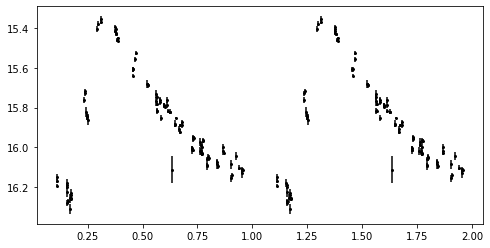

In [4]:
star.plot_lc()

## multi-period detection & amplitude spectrum

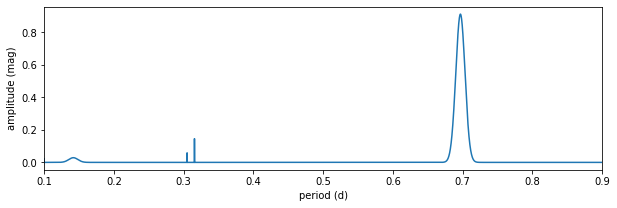

In [5]:
period,spectrum = star.amplitude_spectrum(p_min=0.1,p_max=0.9,N=10)
plt.figure(figsize=(10,3));plt.plot(period,spectrum);plt.xlim(0.1,0.9);plt.xlabel('period (d)');plt.ylabel('amplitude (mag)');plt.show()

## misc: periodogram

---- 0.652 seconds ----


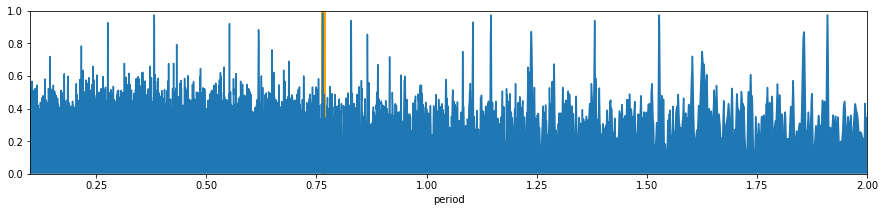

[0.7640485]


In [6]:
# periodogram -- fast method
t0 = time.time()
period,power = star.periodogram(p_min=0.1,p_max=2,Nterms=5,method='fast')
print(f'---- {time.time()-t0:.3f} seconds ----')
plt.figure(figsize=(15,3));plt.plot(period,power);plt.fill_between(period,0,power);plt.xlabel('period');plt.xlim(period.min(),period.max());plt.ylim(0,1);plt.axvline(period[power==power.max()],c='orange',lw=5,zorder=0);plt.show()
print(period[power==power.max()])

---- 9.419 seconds ----


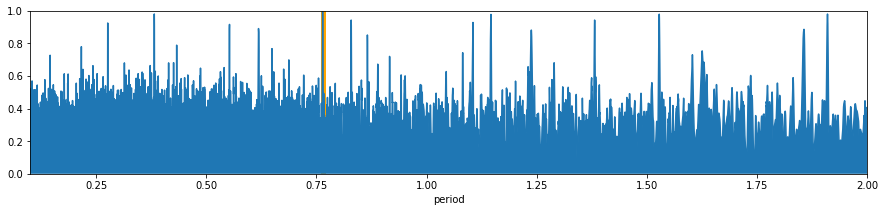

[0.7640485]


In [7]:
# slower but customizable method (users can add custom models)

# Note: this method sometimes raises warnings
#       when cov-matrix cannot be estimated.
#       This does not affect our results, so I'm ignoring warnings.
from warnings import filterwarnings
filterwarnings(action='ignore')

t0 = time.time()
period,power = star.periodogram(p_min=0.1,p_max=2,Nterms=5,method='custom')
print(f'---- {time.time()-t0:.3f} seconds ----')
plt.figure(figsize=(15,3));plt.plot(period,power);plt.fill_between(period,0,power);plt.xlabel('period');plt.xlim(period.min(),period.max());plt.ylim(0,1);plt.axvline(period[power==power.max()],c='orange',lw=5,zorder=0);plt.show()
print(period[power==power.max()])

# Linear Algebra Method
Y.Murakami, 1/3/2020

### data
$i$: data point ($x_i, y_i, \sigma_{y,i}$)<br>
$j$: Fourier term index

$$ 
x_{i} = \left(\begin{matrix} x_0\\ x_1\\ \vdots\\ x_n \end{matrix}\right),\ 
y_{i} = \left(\begin{matrix} y_0\\ y_1\\ \vdots\\ y_n \end{matrix}\right),\ 
\sigma_{y,i} = \left(\begin{matrix} \sigma_{y,0}\\ \sigma_{y,1}\\ \vdots\\ \sigma_{y,n} \end{matrix}\right),\
w_{i} = \frac{1}{\Sigma (1/\sigma_{y,i}^2)}\left(\begin{matrix} 1/\sigma_{y,0}^2\\ 1/\sigma_{y,1}^2\\ \vdots\\ 1/\sigma_{y,n}^2 \end{matrix}\right),\
$$

### Weigted mean, floating mean correction (offset)
$$\langle y \rangle = w_i y_i,\ Y_i = y_i - \langle y \rangle$$


### Model Matrix
$$
X_{ij}(\omega) = \left(\begin{matrix}
\sin(\omega x_0) & \sin(2\omega x_0) & \cdots & \sin(K\omega x_0) & \cos(\omega x_0) & \cos(2\omega x_0) & \cdots & \cos(K\omega x_0) \\
\sin(\omega x_1) & \sin(2\omega x_1) & \cdots & \sin(K\omega x_1) & \cos(\omega x_1) & \cos(2\omega x_1) & \cdots & \cos(K\omega x_1) \\
\vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \ddots & \vdots \\
\sin(\omega x_n) & \sin(2\omega x_n) & \cdots & \sin(K\omega x_n) & \cos(\omega x_n) & \cos(2\omega x_n) & \cdots & \cos(K\omega x_n) \\
\end{matrix}\right)
$$

### Optimization
$$ X_{ij}\theta_{j} = Y_i \quad \Rightarrow \quad X_{ji}X_{ij}\theta_j = X_{ji}Y_i \quad\Rightarrow\quad \theta_j = (X_{ji}X_{ij})^{-1}X_{ji}Y_i$$

### Best-fit values
$$ Y_{i,\text{fit}} = X_{ij}\theta_j $$

### $\chi^2$ and power calculation
$$ 
\chi^2_i = \frac{(y_i - y_{i,fit})^2}{\sigma_{y,i}^2}, \quad
\chi^2_\text{ref} = \frac{(y_i - \langle y \rangle)^2}{\sigma_{y,i}^2} = \frac{Y_i^2}{\sigma_{y,i}^2}
$$

\begin{align*}
\text{Power}(\omega)_i &= \chi^2_\text{ref} - \chi^2_i \\
&= \frac{y_i^2 - 2y_i\langle y \rangle + \langle y \rangle^2 - y_i^2 + 2y_iy_{i,fit} - y_{i,fit}^2}{\sigma_{y,i}^2} \\
&= \frac{2y_i\left(y_{i,fit} - \langle y \rangle\right) + \langle y \rangle^2 - y_{i,fit}^2}{\sigma_{y,i}^2} \\
&= \frac{2y_i\left(y_{i,fit} - \langle y \rangle\right) + \left(\langle y \rangle + y_{i,fit}\right)\left(\langle y \rangle - y_{i,fit}\right)}{\sigma_{y,i}^2} \\
&= \frac{\left(2y_i - \langle y \rangle - y_{i,fit} \right) \left(y_{i,fit} - \langle y \rangle\right) }{\sigma_{y,i}^2} \\
&= \frac{\left(Y_i + \Delta Y_\text{data-fit}\right)Y_{i,fit}}{\sigma_{y,i}^2}
\end{align*}